# Credit Risk Modeling | Part 4: Population Stability Index (PSI) and Model Monitoring

In the previous notebooks, we developed credit risk models (including PD, LGD, and EAD) using Lending Club loan data from 2007 to 2014. In this notebook, we focus on assessing the ongoing performance and stability of our models using data from 2015.

The **credit score** produced by our probability of default (PD) model serves as a quantitative measure of each borrower's creditworthiness. However, over time, changes in the underlying population or macroeconomic environment can lead to a mismatch between the model’s assumptions and the characteristics of new applicants.

To address this, we will calculate and interpret the **Population Stability Index (PSI)**—a key metric for model monitoring. PSI quantifies how much the distribution of credit scores (or any model variable) has shifted between the development (training) sample and the most recent (validation) data. 

A significant difference in distributions may indicate that the model is no longer well-aligned with current applicant profiles, signaling the need for model recalibration or redevelopment to ensure continued predictive accuracy and regulatory compliance.

**Objectives of this notebook:**
- Compare score distributions for the development (2007–2014) and validation (2015) periods
- Calculate the Population Stability Index (PSI)
- Interpret PSI results and provide recommendations for model maintenance

---


## Importing Libraries

In [2]:
#installing gdown package to download dataset stored in G Drive
!pip install gdown
# to upgrade
!pip install --upgrade gdown


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
#libs for managing data
import numpy as np
import pandas as pd

#libs for ML regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics  
from sklearn.metrics import roc_curve, roc_auc_score

#libs for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#exporting ML model
import pickle

#lib to download dataset on g drive
import gdown

#setting display option max rows
#pd.options.display.max_rows = None

#importing custom-made functions
import sys #importing local functions in src folder
sys.path.append('../src/')
from functions import *

## Importing Data

In [4]:
#loading dataset from Gdrive
#fname_2007etp = "https://drive.google.com/file/d/16JXrTBSgEJH4_30zlFFBye1GRHh5h4O0/view?usp=share_link"
#fname_2007etp = 'https://drive.google.com/uc?id=' + fname_2007etp.split('/')[-2]

#updated dataset
fname_2015 = "https://drive.google.com/file/d/1Fb7LFd97aJm0ySb0A48_znfe9KQzaUZO/view?usp=share_link"
fname_2015 = 'https://drive.google.com/uc?id=' + fname_2015.split('/')[-2]

In [5]:
# downloading gdrive files
url = fname_2015
output = "loan_data_2015.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Fb7LFd97aJm0ySb0A48_znfe9KQzaUZO
From (redirected): https://drive.google.com/uc?id=1Fb7LFd97aJm0ySb0A48_znfe9KQzaUZO&confirm=t&uuid=d5212c26-c851-4a4a-989d-9f76cdb22d7e
To: /Users/aish7/Documents/Credit_Risk_Modelling/notebooks/loan_data_2015.csv
100%|██████████| 190M/190M [00:07<00:00, 26.3MB/s] 


'loan_data_2015.csv'

In [6]:
loan_data= pd.read_csv(output)

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_10105/2707309092.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data= pd.read_csv(output)


In [7]:
# test and train datasets were preprocessed in the first notebook.
# they were than stocked over G-drive for the easiness. 
# the links below download the training dataset  from G-Drive
url = "https://drive.google.com/file/d/1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5/view?usp=share_link"
output = "loan_data_inputs_train.csv"
g_down (url,'../data/'+output)

Downloading...
From (original): https://drive.google.com/uc?id=1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5
From (redirected): https://drive.google.com/uc?id=1v45P0HhUxZ1x4HmD0bWblpUyUWuiC0_5&confirm=t&uuid=d8e67966-f9c8-4bda-9704-033baa56f07a
To: /Users/aish7/Documents/Credit_Risk_Modelling/data/loan_data_inputs_train.csv
100%|██████████| 436M/436M [00:16<00:00, 26.1MB/s] 


In [8]:
#loading csv files as pd dataframes
inputs_train = pd.read_csv ('../data/'+'loan_data_inputs_train.csv',index_col =0)

## Exploring Data

In [9]:
# Uncomment below to set the pandas dataframe options to display all columns/ rows.
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None

loan_data.shape

(421094, 74)

In [10]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,68444620,73334399,35000,35000,35000.0,60 months,11.99,778.38,C,C1,...,35367.0,49.3,0.0,1.0,5020.0,40.1,52200.0,1.0,4.0,0.0
1,68547583,73437441,8650,8650,8650.0,36 months,5.32,260.50,A,A1,...,24041.0,88.8,0.0,3.0,3081.0,57.9,26800.0,1.0,0.0,5.0
2,67849662,72708407,4225,4225,4225.0,36 months,14.85,146.16,C,C5,...,3830.0,21.9,0.0,0.0,367.0,22.4,4300.0,0.0,0.0,0.0
3,68506885,73396712,10000,10000,10000.0,60 months,11.99,222.40,C,C1,...,35354.0,75.5,1.0,1.0,3118.0,67.4,14200.0,1.0,1.0,1.0
4,68341763,72928789,20000,20000,20000.0,60 months,10.78,432.66,B,B4,...,10827.0,72.8,0.0,2.0,2081.0,64.7,14000.0,2.0,5.0,1.0


In [11]:
loan_data.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
421089,36371250,39102635,10000,10000,10000.0,36 months,11.99,332.10,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,17100.0,NaN,NaN,NaN
421090,36441262,39152692,24000,24000,24000.0,36 months,11.99,797.03,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,10200.0,NaN,NaN,NaN
421091,36271333,38982739,13000,13000,13000.0,60 months,15.99,316.07,D,D2,...,NaN,NaN,NaN,NaN,NaN,NaN,18000.0,NaN,NaN,NaN
421092,36490806,39222577,12000,12000,12000.0,60 months,19.99,317.86,E,E3,...,NaN,NaN,NaN,NaN,NaN,NaN,27000.0,NaN,NaN,NaN
421093,36271262,38982659,20000,20000,20000.0,36 months,11.99,664.20,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,41700.0,NaN,NaN,NaN


In [12]:
loan_data.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

In [13]:
# Displaying column names with non missing cases and datatype
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           421094 non-null  int64  
 1   member_id                    421094 non-null  int64  
 2   loan_amnt                    421094 non-null  int64  
 3   funded_amnt                  421094 non-null  int64  
 4   funded_amnt_inv              421094 non-null  float64
 5   term                         421094 non-null  object 
 6   int_rate                     421094 non-null  float64
 7   installment                  421094 non-null  float64
 8   grade                        421094 non-null  object 
 9   sub_grade                    421094 non-null  object 
 10  emp_title                    397220 non-null  object 
 11  emp_length                   397277 non-null  object 
 12  home_ownership               421094 non-null  object 
 13 

# 2 General Preprocessing

## a Discrete variables - Dummy columns

In [14]:
dummy_columns = ['grade','sub_grade','home_ownership','verification_status',
                 'loan_status','purpose','addr_state','initial_list_status']

df_Dummies = pd.DataFrame()
for col in dummy_columns:
  df_Dummy= pd.get_dummies(loan_data[col], prefix = col, prefix_sep = ':')
  df_Dummies = pd.concat([df_Dummies,df_Dummy ], axis=1)
  #print(loan_data_Dummies.head())
  # = pd.concat([loan_data,loan_data_Dummies],axis = 1)

In [15]:
#list of all dummy columns. 
df_Dummies.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'grade:G', 'sub_grade:A1', 'sub_grade:A2', 'sub_grade:A3',
       'sub_grade:A4', 'sub_grade:A5', 'sub_grade:B1', 'sub_grade:B2',
       'sub_grade:B3', 'sub_grade:B4', 'sub_grade:B5', 'sub_grade:C1',
       'sub_grade:C2', 'sub_grade:C3', 'sub_grade:C4', 'sub_grade:C5',
       'sub_grade:D1', 'sub_grade:D2', 'sub_grade:D3', 'sub_grade:D4',
       'sub_grade:D5', 'sub_grade:E1', 'sub_grade:E2', 'sub_grade:E3',
       'sub_grade:E4', 'sub_grade:E5', 'sub_grade:F1', 'sub_grade:F2',
       'sub_grade:F3', 'sub_grade:F4', 'sub_grade:F5', 'sub_grade:G1',
       'sub_grade:G2', 'sub_grade:G3', 'sub_grade:G4', 'sub_grade:G5',
       'home_ownership:ANY', 'home_ownership:MORTGAGE',
       'home_ownership:OWN', 'home_ownership:RENT',
       'verification_status:Not Verified',
       'verification_status:Source Verified',
       'verification_status:Verified', 'loan_status:Charged Off',
       'loan_status:Current', 

In [16]:
#merging dummy columns with the main dataset
loan_data = pd.concat([loan_data,df_Dummies],axis = 1)

## b Continuous variables - Dt format conversion

In [17]:
#lets convert emp_length into integer
loan_data['emp_length'].unique()

array(['10+ years', '< 1 year', '5 years', '3 years', '4 years', nan,
       '2 years', '8 years', '9 years', '1 year', '6 years', '7 years'],
      dtype=object)

In [18]:
# Clean 'emp_length' strings before conversion
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace(r'\+ years', '', regex=True)  # Remove '+ years'
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(r'< 1 year', '0', regex=True)  # Replace '< 1 year' with '0'
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(r'n/a', '0', regex=True)  # Replace 'n/a' with '0'
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(r' years?', '', regex=True)  # Remove ' year' or ' years'

# Now convert to numeric
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])


In [19]:
# date variables not in dt format
loan_data['earliest_cr_line']

0         Feb-90
1         Jul-01
2         Jul-11
3         Dec-98
4         Aug-00
           ...  
421089    Sep-04
421090    Mar-74
421091    Sep-03
421092    Oct-03
421093    Dec-01
Name: earliest_cr_line, Length: 421094, dtype: object

In [20]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y')

loan_data['earliest_cr_line_period'] = loan_data['earliest_cr_line_date'].dt.to_period('M')
ref_period = pd.Period('2017-12', freq='M')

loan_data['mths_since_earliest_cr_line'] = (ref_period - loan_data['earliest_cr_line_period']).apply(lambda x: x.n)


In [21]:
loan_data['mths_since_earliest_cr_line'].describe()

count    421094.000000
mean        227.354876
std          98.123989
min        -612.000000
25%         167.000000
50%         212.000000
75%         277.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [22]:
#finding out why there are negative values in our dataset
m1 = loan_data['mths_since_earliest_cr_line']<0
loan_data.loc[m1,['earliest_cr_line','earliest_cr_line_date','mths_since_earliest_cr_line']].head()

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
254,Jan-57,2057-01-01,-469
618,Aug-64,2064-08-01,-560
648,Jul-68,2068-07-01,-607
1808,Jan-65,2065-01-01,-565
2583,Sep-64,2064-09-01,-561


In [23]:
# it is neccessary to handle negative values. they are due to the 196x data read as 206x
# we take the maximum month difference to replace negative values
loan_data.loc[m1,'mths_since_earliest_cr_line'] = loan_data.loc[:,'mths_since_earliest_cr_line'].max()

In [24]:
#let's convert term column to integer format
loan_data['term']

0          60 months
1          36 months
2          36 months
3          60 months
4          60 months
             ...    
421089     36 months
421090     36 months
421091     60 months
421092     60 months
421093     36 months
Name: term, Length: 421094, dtype: object

In [25]:
loan_data['term_int'] = loan_data['term'].str.replace(' months', '').astype(int)
loan_data['term_int'].describe()

count    421094.000000
mean         43.860782
std          11.263533
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: term_int, dtype: float64

In [26]:
# Assuming we are in December 2017
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
loan_data['issue_d_period'] = loan_data['issue_d_date'].dt.to_period('M')
ref_period = pd.Period('2017-12', freq='M')

loan_data['mths_since_issue_d'] = (ref_period - loan_data['issue_d_period']).apply(lambda x: x.n)

# Showing some descriptive statisics for the values of a column.
loan_data['mths_since_issue_d'].describe()

count    421094.000000
mean         29.044629
std           3.458162
min          24.000000
25%          26.000000
50%          29.000000
75%          32.000000
max          35.000000
Name: mths_since_issue_d, dtype: float64

## c Checking for missing values or cleaning them

In [27]:
pd.options.display.max_rows = None
loan_data.isnull().sum().sort_values(ascending=False)

desc                                   421049
dti_joint                              420585
verification_status_joint              420583
annual_inc_joint                       420583
il_util                                402477
mths_since_rcnt_il                     400284
open_il_24m                            399722
inq_fi                                 399722
inq_last_12m                           399722
open_acc_6m                            399722
open_il_6m                             399722
open_il_12m                            399722
total_cu_tl                            399722
max_bal_bc                             399722
all_util                               399722
total_bal_il                           399722
open_rv_12m                            399722
open_rv_24m                            399722
mths_since_last_record                 346679
mths_since_last_major_derog            298365
mths_since_last_delinq                 203961
next_pymnt_d                      

In [28]:
# filling up the empty rows that will be used in our model.
# we use funded_amnt for the missing total_rev_hi_lim values
# fundedAmnt The total amount committed to that loan at that point in time.
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'],inplace = True)

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_10105/4064530569.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'],inplace = True)


In [29]:
# for the missing values in annual_inc, mean value is considered.  
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(),inplace = True)

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_10105/4273484639.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(),inplace = True)


In [30]:
# for the missing values below, we consider 0
loan_data['mths_since_earliest_cr_line'].fillna(0,inplace = True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_10105/3148015446.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data['mths_since_earliest_cr_line'].fillna(0,inplace = True)
/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_10105/3148015446.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

##**d Preprocessing of discrete variables**

We apply the same preprocessing as done in L01 notebook.


In [31]:
#running preproc on test dataset
loan_data_2015= preproc_input_data2015 (loan_data)
loan_data_2015.columns.values

/Users/aish7/Documents/Credit_Risk_Modelling/notebooks/../src/functions.py:593: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
/Users/aish7/Documents/Credit_Risk_Modelling/notebooks/../src/functions.py:594: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)
/Users/aish7/Documents/Credit_Risk_Modelling/notebooks/../src/functions.py:598: PerformanceWa

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

In [32]:
# We commented on some features, the coefficients for all or almost all of the dummy variables for which,
# are not statistically significant.
# Refined variables
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'mths_since_earliest_cr_line:141-164',
#'mths_since_earliest_cr_line:165-247',
#'mths_since_earliest_cr_line:248-270',
#'mths_since_earliest_cr_line:271-352',
#'mths_since_earliest_cr_line:>352',
#'delinq_2yrs:0',
#'delinq_2yrs:1-3',
#'delinq_2yrs:>=4',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
#'open_acc:0',
#'open_acc:1-3',
#'open_acc:4-12',
#'open_acc:13-17',
#'open_acc:18-22',
#'open_acc:23-25',
#'open_acc:26-30',
#'open_acc:>=31',
'pub_rec:0-2',
'pub_rec:3-4',
'pub_rec:>=5',
#'total_acc:<=27',
#'total_acc:28-51',
#'total_acc:>=52',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'total_rev_hi_lim:<=5K',
'total_rev_hi_lim:5K-10K',
'total_rev_hi_lim:10K-20K',
'total_rev_hi_lim:20K-30K',
'total_rev_hi_lim:30K-40K',
'total_rev_hi_lim:40K-55K',
'total_rev_hi_lim:55K-95K',
'total_rev_hi_lim:>95K',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
#'mths_since_last_delinq:Missing',
#'mths_since_last_delinq:0-3',
#'mths_since_last_delinq:4-30',
#'mths_since_last_delinq:31-56',
#'mths_since_last_delinq:>=57',
#'mths_since_last_record:Missing',
#'mths_since_last_record:0-2',
#'mths_since_last_record:3-20',
#'mths_since_last_record:21-31',
#'mths_since_last_record:32-80',
#'mths_since_last_record:81-86',
#'mths_since_last_record:>=86',
]


In [33]:

ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'int_rate:>20.281',
#'mths_since_earliest_cr_line:<140',
#'delinq_2yrs:>=4',
'inq_last_6mths:>6',
#'open_acc:0',
'pub_rec:0-2',
#'total_acc:<=27',
'acc_now_delinq:0',
'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35'
#'mths_since_last_delinq:0-3',
#'mths_since_last_record:0-2'
]

In [34]:
inputs_2015_With_ref_cat = loan_data_2015.loc[:,features_all]

In [35]:
# loading values of df in a new dataframe.   
inputs_train_With_ref_categories = inputs_train.loc[: ,features_all]
 
inputs_train_With_ref_categories.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,...,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35
427211,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
206088,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
136020,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
412305,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
36159,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [36]:
inputs_2015_With_ref_cat.shape

(421094, 86)

# 3 Calculating scores from a score card

In [36]:
#url = 'https://drive.google.com/file/d/1XU0CwMv2skhc_P_LHiDZzUx1N0kEW2Rg/view?usp=share_link'
#output = 'df_scorecard.csv'
#g_down (url,output)


df_scorecard = pd.read_csv ('../data/df_scorecard.csv',index_col= 0)

In [37]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Score - Final,Difference
0,0,Intercept,0.260534,NaN,Intercept,359.931207,360.0,360.0,0.068793
1,1,grade:A,0.231117,7.824576e-03,grade,21.551286,22.0,22.0,0.448714
2,2,grade:B,0.305899,2.005733e-07,grade,28.524539,29.0,29.0,0.475461
3,3,grade:C,0.302560,4.430795e-08,grade,28.213208,28.0,28.0,-0.213208
4,4,grade:D,0.296830,2.388592e-08,grade,27.678908,28.0,28.0,0.321092
5,5,grade:E,0.263596,2.787046e-08,grade,24.579878,25.0,25.0,0.420122
6,6,grade:F,0.116838,1.796584e-02,grade,10.894903,11.0,11.0,0.105097
7,7,home_ownership:OWN,0.123303,8.821549e-10,home_ownership,11.497805,11.0,11.0,-0.497805
8,8,home_ownership:MORTGAGE,0.124315,4.050512e-23,home_ownership,11.592199,12.0,12.0,0.407801
9,9,addr_state:NM_VA,0.037084,2.459599e-01,addr_state,3.457980,3.0,3.0,-0.457980


In [38]:
inputs_train_With_ref_cat_w_intercept = inputs_train_With_ref_categories
inputs_train_With_ref_cat_w_intercept.insert(0,'Intercept', 1)
inputs_train_With_ref_cat_w_intercept = inputs_train_With_ref_cat_w_intercept[df_scorecard['Feature name'].values]
inputs_train_With_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,...,initial_list_status:f,term:60,emp_length:0,int_rate:>20.281,inq_last_6mths:>6,pub_rec:0-2,acc_now_delinq:0,total_rev_hi_lim:<=5K,annual_inc:<20K,dti:>35
427211,1,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
206088,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
136020,1,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
412305,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
36159,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0


In [39]:
inputs_2015_With_ref_cat_w_intercept = inputs_2015_With_ref_cat
inputs_2015_With_ref_cat_w_intercept.insert(0,'Intercept', 1)
inputs_2015_With_ref_cat_w_intercept = inputs_2015_With_ref_cat_w_intercept[df_scorecard['Feature name'].values]
inputs_2015_With_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,...,initial_list_status:f,term:60,emp_length:0,int_rate:>20.281,inq_last_6mths:>6,pub_rec:0-2,acc_now_delinq:0,total_rev_hi_lim:<=5K,annual_inc:<20K,dti:>35
0,1,False,False,True,False,False,False,False,True,0,...,False,1,0,0,0,1,1,0,0,0
1,1,True,False,False,False,False,False,False,True,0,...,False,0,1,0,0,1,1,0,0,0
2,1,False,False,True,False,False,False,False,False,0,...,False,0,0,0,0,1,1,1,0,0
3,1,False,False,True,False,False,False,False,False,0,...,False,1,0,0,0,1,1,0,0,0
4,1,False,True,False,False,False,False,False,True,0,...,False,1,0,0,0,1,1,0,0,0


In [40]:
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(87,1)

In [41]:
y_scores_train = inputs_train_With_ref_cat_w_intercept.dot(scorecard_scores)
y_scores_train.head()

,0
427211,648.0
206088,567.0
136020,640.0
412305,456.0
36159,492.0


In [42]:
y_scores_2015 = inputs_2015_With_ref_cat_w_intercept.dot(scorecard_scores)
y_scores_2015.head()

,0
0,689.0
1,693.0
2,551.0
3,552.0
4,627.0


In [43]:
inputs_train_with_ref_cat_w_intercept = pd.concat([inputs_train_With_ref_cat_w_intercept, y_scores_train], axis = 1)
inputs_2015_with_ref_cat_w_intercept = pd.concat([inputs_2015_With_ref_cat_w_intercept, y_scores_2015], axis = 1)

In [44]:
inputs_train_with_ref_cat_w_intercept.columns.values[inputs_train_with_ref_cat_w_intercept.shape[1]-1] = 'Score'
inputs_2015_with_ref_cat_w_intercept.columns.values[inputs_2015_with_ref_cat_w_intercept.shape[1]-1] = 'Score'

In [45]:
# Creating dummy variables for score intervals with old (\"expected\")."
inputs_train_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 300) & (inputs_train_with_ref_cat_w_intercept['Score'] < 350), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 350) & (inputs_train_with_ref_cat_w_intercept['Score'] < 400), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 400) & (inputs_train_with_ref_cat_w_intercept['Score'] < 450), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 450) & (inputs_train_with_ref_cat_w_intercept['Score'] < 500), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 500) & (inputs_train_with_ref_cat_w_intercept['Score'] < 550), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 550) & (inputs_train_with_ref_cat_w_intercept['Score'] < 600), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 600) & (inputs_train_with_ref_cat_w_intercept['Score'] < 650), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 650) & (inputs_train_with_ref_cat_w_intercept['Score'] < 700), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 700) & (inputs_train_with_ref_cat_w_intercept['Score'] < 750), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 750) & (inputs_train_with_ref_cat_w_intercept['Score'] < 800), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 800) & (inputs_train_with_ref_cat_w_intercept['Score'] <= 850), 1, 0)


In [46]:
# Creating dummy variables for score intervals with new (\"actual\").
inputs_2015_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 300) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 350), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 350) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 400), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 400) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 450), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 450) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 500), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 500) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 550), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 550) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 600), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 600) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 650), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 650) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 700), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 700) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 750), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 750) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 800), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 800) & (inputs_2015_with_ref_cat_w_intercept['Score'] <= 850), 1, 0)

# 4 Population Stability Index

It is calculated with the following formula:  
PSI = [Proportions w/ new data - Proportions w train data ] x ln (Proportions w/ new data / Proportions w train data)

In [49]:
import numpy as np

# Check sums of proportions
print(f"Sum of train proportions: {PSI_calc['Prop_Train'].sum()}")
print(f"Sum of new proportions: {PSI_calc['Prop_New'].sum()}")

# Check for any zeros (should be replaced now)
print(f"Zero values in train props: {(PSI_calc['Prop_Train'] == 0).sum()}")
print(f"Zero values in new props: {(PSI_calc['Prop_New'] == 0).sum()}")

# Check for NaNs or infinities in Contribution
print(f"NaNs in Contribution: {PSI_calc['Contribution'].isna().sum()}")
PSI_calc['Contribution'] = pd.to_numeric(PSI_calc['Contribution'], errors='coerce')
print(f"Infinite values in Contribution: {(np.isinf(PSI_calc['Contribution'])).sum()}")

# Total PSI value
total_psi = PSI_calc['Contribution'].sum()
print(f"Total PSI: {total_psi:.6f}")


Sum of train proportions: 15.999999999999998
Sum of new proportions: 15.999999999999993
Zero values in train props: 1
Zero values in new props: 2
NaNs in Contribution: 0
Infinite values in Contribution: 0
Total PSI: 0.851696


In [48]:
# Assuming these two DataFrames exist and have the same columns (features + intercept)
# Calculate proportions for train and new data
PSI_calc_train = inputs_train_with_ref_cat_w_intercept.sum() / inputs_train_with_ref_cat_w_intercept.shape[0]
PSI_calc_2015 = inputs_2015_with_ref_cat_w_intercept.sum() / inputs_2015_with_ref_cat_w_intercept.shape[0]

# Concatenate proportions side by side
PSI_calc = pd.concat([PSI_calc_train, PSI_calc_2015], axis=1)

# Reset index for ease of manipulation
PSI_calc = PSI_calc.reset_index()

# Convert index column to string for string operations
PSI_calc['index'] = PSI_calc['index'].astype(str)

# Extract original feature name (before colon) into new column
PSI_calc['Orig feature'] = PSI_calc['index'].str.split(':').str[0]

# Rename columns for clarity
PSI_calc.columns = ['index', 'Prop_Train', 'Prop_New', 'Orig feature']

# Keep relevant columns
PSI_calc = PSI_calc[['index', 'Orig feature', 'Prop_Train', 'Prop_New']]

# Remove rows for intercept or score
PSI_calc = PSI_calc[(PSI_calc['index'] != 'Intercept') & (PSI_calc['index'] != 'Score')]


# Replace zero proportions with a very small positive value to avoid division by zero
prop_train_safe = PSI_calc['Prop_Train'].replace(0, 1e-10)
prop_new_safe = PSI_calc['Prop_New'].replace(0, 1e-10)

# Calculate the PSI contribution safely
PSI_calc['Contribution'] = np.where(
    (PSI_calc['Prop_Train'] == 0) | (PSI_calc['Prop_New'] == 0),
    0,
    (PSI_calc['Prop_New'] - PSI_calc['Prop_Train']) * np.log(prop_new_safe / prop_train_safe)
)


PSI_calc


/var/folders/y6/98pzw41d19qg3qhnh3w7nxdh00cyh4/T/ipykernel_10105/2570518928.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prop_new_safe = PSI_calc['Prop_New'].replace(0, 1e-10)


,index,Orig feature,Prop_Train,Prop_New,Contribution
1,grade:A,grade,0.160200,0.174154,0.001165
2,grade:B,grade,0.294160,0.279287,0.000772
3,grade:C,grade,0.268733,0.286318,0.001115
4,grade:D,grade,0.164862,0.148789,0.001649
5,grade:E,grade,0.076702,0.082993,0.000496
6,grade:F,grade,0.028228,0.023313,0.00094
7,home_ownership:OWN,home_ownership,0.089256,0.108684,0.003826
8,home_ownership:MORTGAGE,home_ownership,0.506546,0.493196,0.000357
9,addr_state:NM_VA,addr_state,0.036032,0.034159,0.0001
10,addr_state:NY,addr_state,0.086350,0.080372,0.000429


In [51]:
def calculate_feature_psi(train_df, new_df, feature_prefix):
    # Select columns for that feature based on prefix
    cols = [col for col in train_df.columns if col.startswith(feature_prefix)]
    
    # Calculate proportions per category
    train_props = train_df[cols].sum() / train_df.shape[0]
    new_props = new_df[cols].sum() / new_df.shape[0]
    
    # Normalize proportions to sum to 1 (if needed)
    train_props = train_props / train_props.sum()
    new_props = new_props / new_props.sum()
    
    # Replace zeros to avoid div by zero
    train_props_safe = train_props.replace(0, 1e-10)
    new_props_safe = new_props.replace(0, 1e-10)
    
    # Compute PSI per category
    psi_contrib = (new_props - train_props) * np.log(new_props_safe / train_props_safe)
    
    # Sum PSI over categories for the feature
    feature_psi = psi_contrib.sum()
    
    return feature_psi, psi_contrib

# Example usage for 'grade' feature:
grade_psi, grade_contribs = calculate_feature_psi(inputs_train_with_ref_cat_w_intercept, inputs_2015_with_ref_cat_w_intercept, 'grade:')
print(f"PSI for 'grade': {grade_psi}")


PSI for 'grade': 0.006774525567293313


In [50]:
# Summing all contributions by original feature name
PSI_calc.groupby('Orig feature')['Contribution'].sum()

Orig feature
Score                  0.142769
acc_now_delinq         0.000925
addr_state             0.003837
annual_inc             0.005445
dti                    0.078143
emp_length             0.007619
grade                  0.006775
home_ownership         0.004275
initial_list_status    0.333717
inq_last_6mths         0.046465
int_rate               0.079230
pub_rec                0.004508
purpose                0.011645
term                   0.013099
total_rev_hi_lim       0.065026
verification_status    0.048219
Name: Contribution, dtype: float64

In [52]:
feature_psi = PSI_calc.groupby('Orig feature')['Contribution'].sum().reset_index()
feature_psi = feature_psi.sort_values(by='Contribution', ascending=False)
print(feature_psi)


           Orig feature  Contribution
8   initial_list_status      0.333717
0                 Score      0.142769
10             int_rate      0.079230
4                   dti      0.078143
14     total_rev_hi_lim      0.065026
15  verification_status      0.048219
9        inq_last_6mths      0.046465
13                 term      0.013099
12              purpose      0.011645
5            emp_length      0.007619
6                 grade      0.006775
3            annual_inc      0.005445
11              pub_rec      0.004508
7        home_ownership      0.004275
2            addr_state      0.003837
1        acc_now_delinq      0.000925


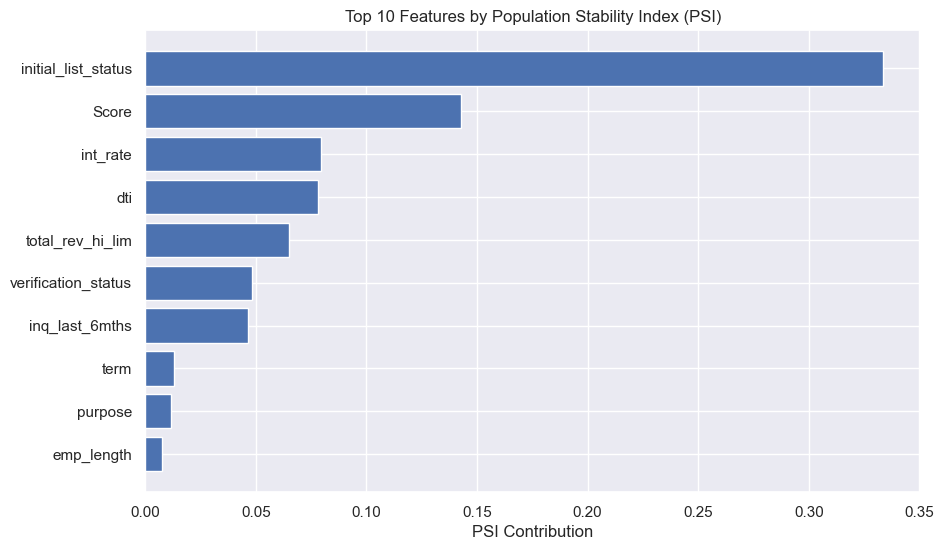

In [53]:
import matplotlib.pyplot as plt

top_features = feature_psi.head(10)
plt.figure(figsize=(10,6))
plt.barh(top_features['Orig feature'], top_features['Contribution'])
plt.xlabel('PSI Contribution')
plt.title('Top 10 Features by Population Stability Index (PSI)')
plt.gca().invert_yaxis()
plt.show()


**Interpret the PSI values:**

initial_list_status has the largest shift by far (~0.33), so it’s the feature with the most population drift.

Score and int_rate also show moderate shifts.

Features like term, purpose, and emp_length have smaller shifts.**

In [58]:
# Group by original feature and sum contributions
feature_psi = PSI_calc.groupby('Orig feature')['Contribution'].sum().sort_values(ascending=False)

print(feature_psi)


Orig feature
initial_list_status    0.333717
Score                  0.142769
int_rate               0.079230
dti                    0.078143
total_rev_hi_lim       0.065026
verification_status    0.048219
inq_last_6mths         0.046465
term                   0.013099
purpose                0.011645
emp_length             0.007619
grade                  0.006775
annual_inc             0.005445
pub_rec                0.004508
home_ownership         0.004275
addr_state             0.003837
acc_now_delinq         0.000925
Name: Contribution, dtype: float64


In [59]:
def psi_interpret(psi):
    if psi < 0.1:
        return 'Stable'
    elif psi < 0.25:
        return 'Moderate shift'
    else:
        return 'Significant shift'

psi_summary = feature_psi.reset_index()
psi_summary['Interpretation'] = psi_summary['Contribution'].apply(psi_interpret)

print(psi_summary)


           Orig feature  Contribution     Interpretation
0   initial_list_status      0.333717  Significant shift
1                 Score      0.142769     Moderate shift
2              int_rate      0.079230             Stable
3                   dti      0.078143             Stable
4      total_rev_hi_lim      0.065026             Stable
5   verification_status      0.048219             Stable
6        inq_last_6mths      0.046465             Stable
7                  term      0.013099             Stable
8               purpose      0.011645             Stable
9            emp_length      0.007619             Stable
10                grade      0.006775             Stable
11           annual_inc      0.005445             Stable
12              pub_rec      0.004508             Stable
13       home_ownership      0.004275             Stable
14           addr_state      0.003837             Stable
15       acc_now_delinq      0.000925             Stable


initial_list_status has a significant shift (PSI > 0.25), meaning the distribution between train and new data changed notably.

Score has a moderate shift (0.1 < PSI < 0.25), so keep an eye on this feature as well.

All other features appear stable for now.

This project ends up here but the models (PD, LGD, EAD) can be re-trained as shown in notebooks L02 and L03 with more recent data. 

## Results: Population Stability Index (PSI) and Model Monitoring

### 1. Overall PSI Value

- The **total PSI** comparing credit score distributions between the development (2007–2014) and validation (2015) samples is **0.85**.
    - A PSI above 0.25 typically signals significant population drift, suggesting that the characteristics of the new applicants have changed considerably compared to the original training set.

---

### 2. Feature-Level PSI Analysis

- **Features with the largest population shifts:**
    - **initial_list_status:** PSI = 0.33 (**Significant shift**)
        - This feature has the highest contribution, indicating a substantial change in how loans are initially listed between training and validation periods.
    - **Score:** PSI = 0.14 (**Moderate shift**)
        - The overall distribution of credit scores has shifted, which may impact the performance of the PD model.
    - **int_rate, dti, total_rev_hi_lim, verification_status, inq_last_6mths:** PSI values range from ~0.05 to 0.08 (**Stable to Moderate shifts**)
        - Moderate changes in these features suggest evolving borrower profiles, but not to a critical extent.
    - **All other features** (e.g., purpose, emp_length, grade, annual_inc, addr_state) have **PSI < 0.1** and are considered **stable**.

| Feature               | PSI Value  | Interpretation      |
|-----------------------|-----------|---------------------|
| initial_list_status   | 0.33      | Significant shift   |
| Score                 | 0.14      | Moderate shift      |
| int_rate              | 0.08      | Stable              |
| dti                   | 0.08      | Stable              |
| total_rev_hi_lim      | 0.07      | Stable              |
| verification_status   | 0.05      | Stable              |
| ...                   | ...       | ...                 |

---

### 3. Interpretation and Model Implications

- **Significant drift in initial_list_status** and a **moderate shift in credit scores** indicate that the PD model may no longer be fully aligned with the 2015 applicant population.
- **Other features remain stable**, supporting model robustness for those variables.
- A total PSI > 0.25 suggests **retraining or recalibration of the PD model is advisable** to ensure predictive accuracy and compliance.
- **Ongoing monitoring** is recommended as part of model risk management.

---

### 4. Conclusion

- The Population Stability Index analysis highlights where the data distribution has changed most, helping prioritize features and periods for model updates.
- To maintain model performance, a refresh using more recent data is warranted, particularly addressing features with high PSI contributions.

---

**This concludes the project. Future work may involve retraining the PD, LGD, and EAD models as demonstrated in earlier notebooks, using updated loan data to reflect current borrower characteristics.**


--- End of Notebook ---
# END